In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kazanova/sentiment140")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sentiment140


In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import nltk
from nltk.corpus import stopwords
import string
import re
import plotly.express as px
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")
df.columns = ["label", "time", "date", "query", "username", "text"]

In [5]:
df.head(5)

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


##EDA

###nums of post by Day/Week/Month

In [7]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

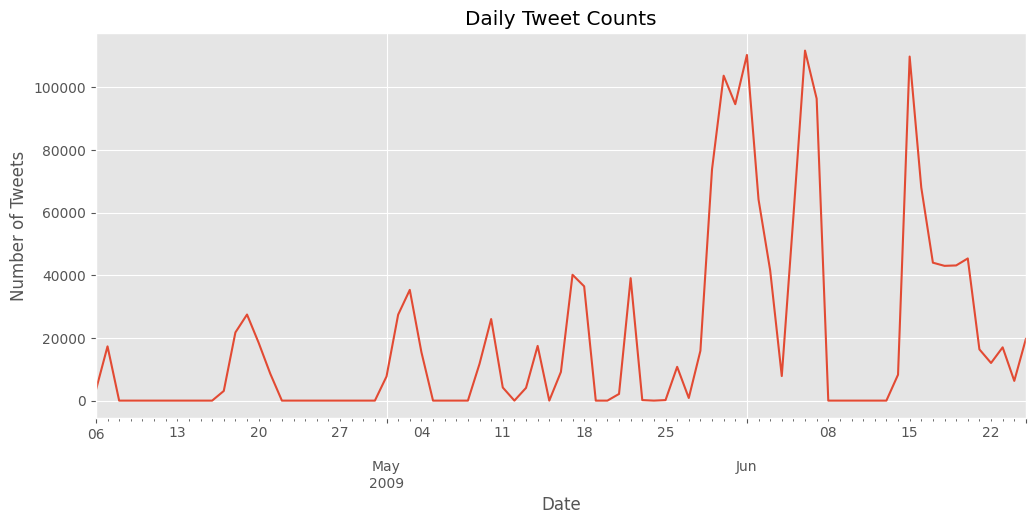

In [8]:
daily_counts = df.resample('D').size()
daily_counts.plot(figsize=(12, 5), title='Daily Tweet Counts')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()


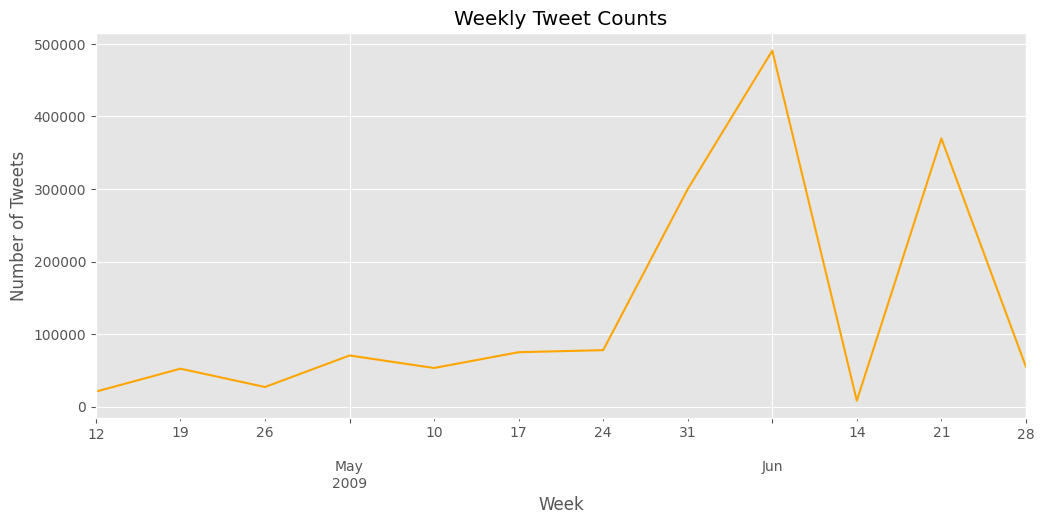

In [9]:
weekly_counts = df.resample('W').size()
weekly_counts.plot(figsize=(12, 5), title='Weekly Tweet Counts', color='orange')
plt.xlabel('Week')
plt.ylabel('Number of Tweets')
plt.show()


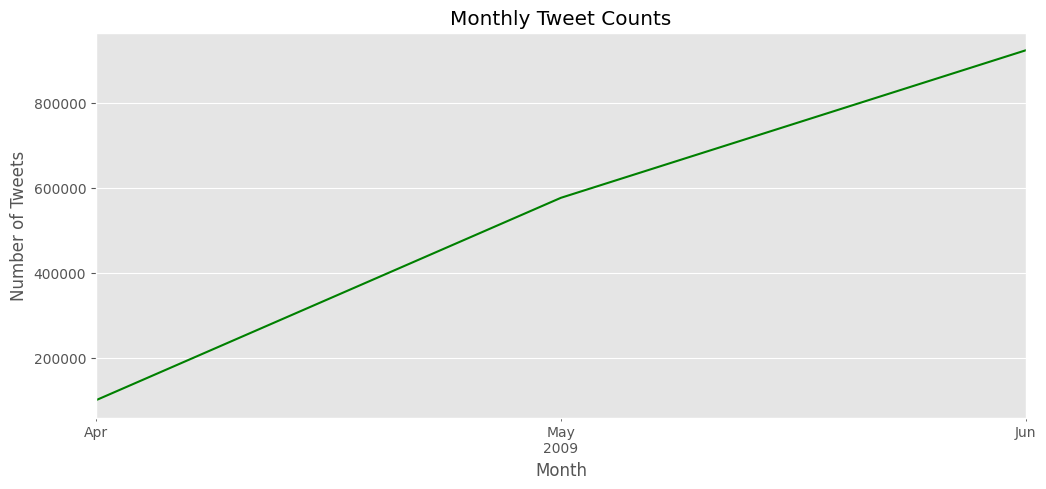

In [10]:
monthly_counts = df.resample('M').size()
monthly_counts.plot(figsize=(12, 5), title='Monthly Tweet Counts', color='green')
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.show()

In [11]:
df.reset_index(inplace=True)

###TOP 10 active users

Top 10 Active Users:
 username
lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
mcraddictal        276
tsarnick           248
what_bugs_u        246
Karen230683        238
DarkPiano          236
Name: count, dtype: int64


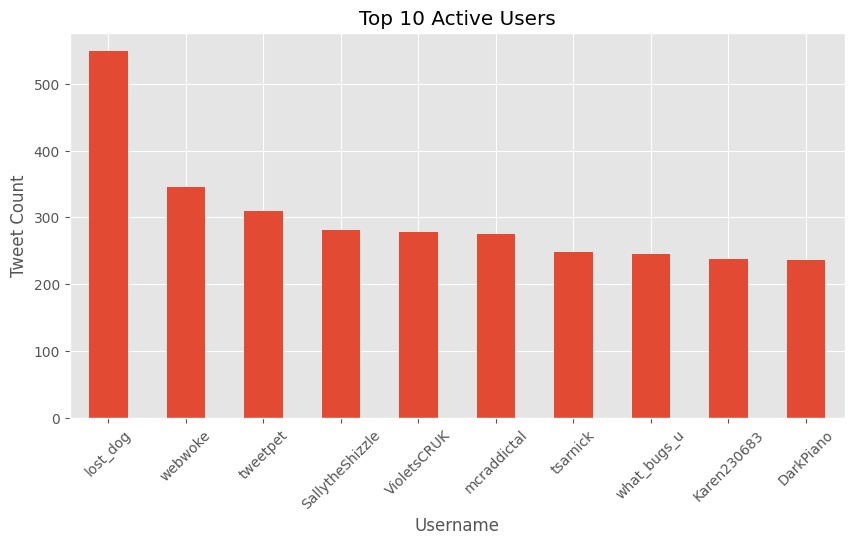

In [12]:
top_users = df['username'].value_counts().head(10)

print("Top 10 Active Users:\n", top_users)

top_users.plot(kind='bar', figsize=(10,5), title='Top 10 Active Users')
plt.xlabel('Username')
plt.ylabel('Tweet Count')
plt.xticks(rotation=45)
plt.show()


###TOP 10 shared tweets

Top 10 Shared Tweets:
 text
isPlayer Has Died! Sorry                                                                          210
good morning                                                                                      118
headache                                                                                          115
Good morning                                                                                      112
Headache                                                                                          106
Not to worry, noone got that one. Next question starts in 1 minute, get your thinking caps on      86
 cant afford to see Angels and Demons, so i watched it for free: http://tr.im/lvBu                 86
Goodnight                                                                                          85
my tummy hurts                                                                                     81
Jogging, isnt REALLY that cool, especially if you've g

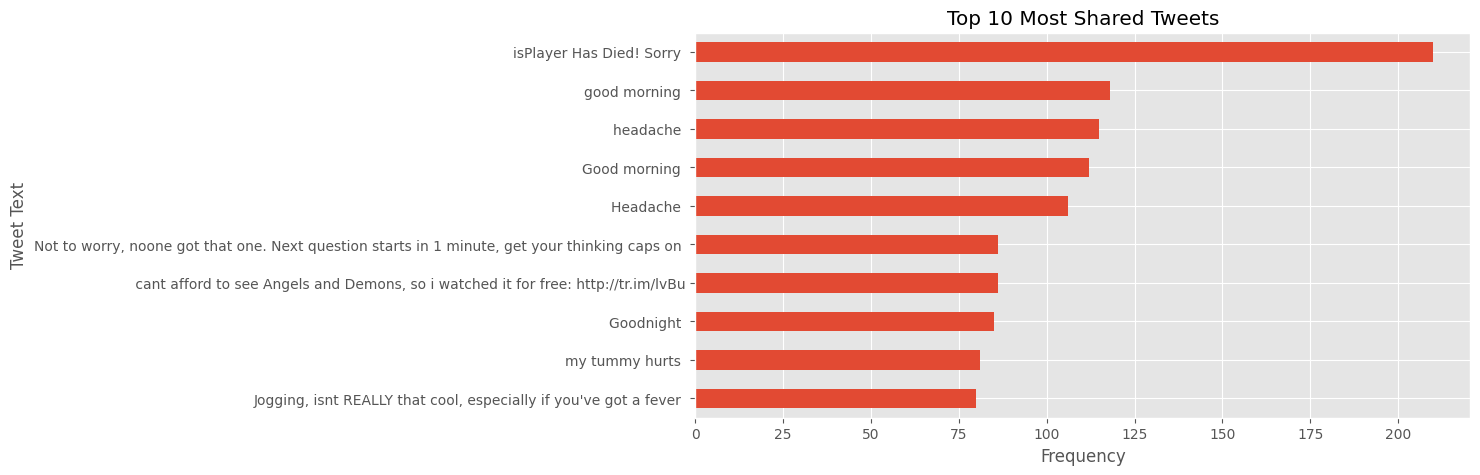

In [13]:
top_shared = df['text'].value_counts().head(10)

print("Top 10 Shared Tweets:\n", top_shared)

top_shared.plot(kind='barh', figsize=(10,5), title='Top 10 Most Shared Tweets')
plt.xlabel('Frequency')
plt.ylabel('Tweet Text')
plt.gca().invert_yaxis()
plt.show()


In [14]:
df.head()

,date,label,time,query,username,text
0,2009-04-06 22:19:49,0,1467810672,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,2009-04-06 22:19:53,0,1467810917,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,2009-04-06 22:19:57,0,1467811184,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,2009-04-06 22:19:57,0,1467811193,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,2009-04-06 22:20:00,0,1467811372,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


###Sentiment Label Distribution

In [15]:
temp_copy = df.copy()
temp_copy['label'] = temp_copy['label'].replace({0: 'negative', 4: 'positive'})
temp = temp_copy.groupby('label').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp

,label,text
1,positive,800000
0,negative,799999


<Axes: title={'center': 'Sentiment Label Distribution'}, xlabel='Sentiment Label', ylabel='Tweet Count'>

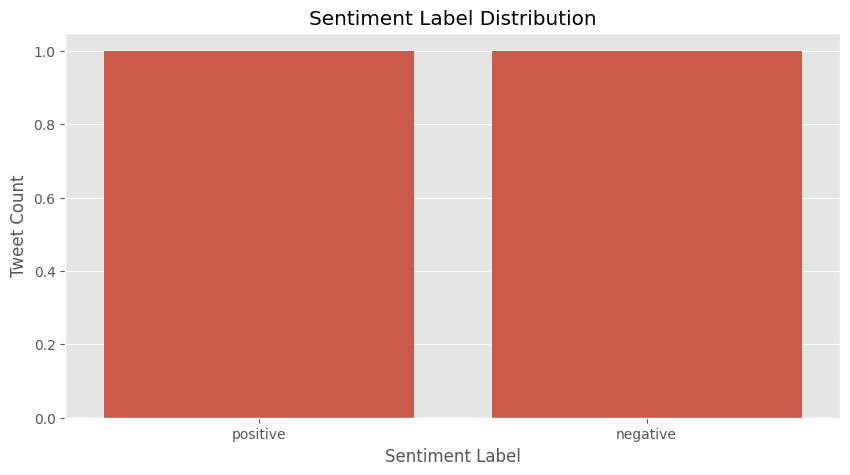

In [18]:
plt.figure(figsize=(10, 5))
plt.title("Sentiment Label Distribution")
plt.xlabel("Sentiment Label")
plt.ylabel("Tweet Count")
sns.countplot(x='label',data=temp)

###Tweet Length by Sentiment

Text(0.5, 1.0, 'Tweet Length by Sentiment')

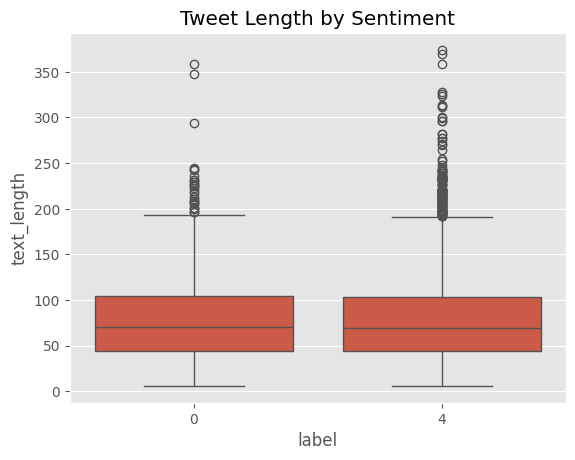

In [19]:
df['text_length'] = df['text'].apply(len)
sns.boxplot(x='label', y='text_length', data=df)
plt.title('Tweet Length by Sentiment')

###Average Sentiment Over Time

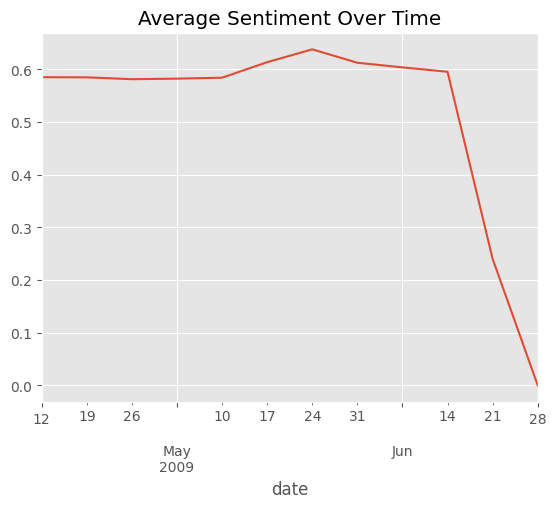

In [20]:
df.set_index('date', inplace=True)
df['sentiment'] = df['label'].map({0: 0, 4: 1})
sentiment_trend = df.resample('W')['sentiment'].mean()
sentiment_trend.plot(title='Average Sentiment Over Time')
df.reset_index(inplace=True)

###Clean Text and Stopwords

In [25]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [35]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text) #[]
    text = re.sub('https?://\S+|www\.\S+', '', text) #website
    text = re.sub('<.*?>+', '', text) #html
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #,./
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('@[^\s]+', ' ', text) #email
    text = re.sub('[0-9]+', '', text) #number

    return text

stop_words = set(stopwords.words('english'))
stop_words.update(['im','got','get','u','one'])

# def remove_stopword(text):
#     words = text.split()
#     return ' '.join([w for w in words if w.lower() not in stop_words])
def remove_stopword(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

In [27]:
df['text'] = df['text'].apply(lambda x:clean_text(x))

In [36]:
df['text'] = df['text'].apply(remove_stopword)

###Common Words in Texts

In [37]:
all_words = ' '.join(df['text']).split()
top = Counter(all_words)
temp = pd.DataFrame(top.most_common(20), columns=['Common_words', 'count'])
temp.style.background_gradient(cmap='Purples')

,Common_words,count
0,good,89380
1,day,82354
2,like,77721
3,go,72892
4,dont,66894
5,today,64596
6,going,64079
7,love,63433
8,work,62833
9,cant,62586


In [38]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [39]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [40]:
positive_sent = df[df['label']== 4]
negative_sent = df[df['label']== 0]

In [41]:
positive_words = ' '.join(positive_sent['text']).split()
top = Counter(positive_words)
temp_positive = pd.DataFrame(top.most_common(20), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Purples')

,Common_words,count
0,good,60832
1,love,46815
2,day,44356
3,like,37095
4,thanks,33721
5,lol,33463
6,going,30641
7,time,29331
8,today,28406
9,go,27777


In [42]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [43]:
negative_words = ' '.join(negative_sent['text']).split()
top = Counter(negative_words)
temp_negative = pd.DataFrame(top.most_common(20), columns=['Common_words', 'count'])
temp_negative.style.background_gradient(cmap='Purples')

,Common_words,count
0,go,45115
1,dont,44898
2,work,44053
3,cant,43584
4,like,40626
5,day,37998
6,today,36190
7,going,33438
8,back,32512
9,really,31217


In [44]:
fig = px.bar(temp_negative, x="count", y="Common_words", title='Most Commmon Negative Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

###WordCloud

In [45]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def plot_wordcloud(text, max_words=200, max_font_size=100, figure_size=(10,5), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im", "one"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=400,
                    height=200)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud);
    plt.title(title, fontdict={'size': title_size, 'color': 'black',
                              'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

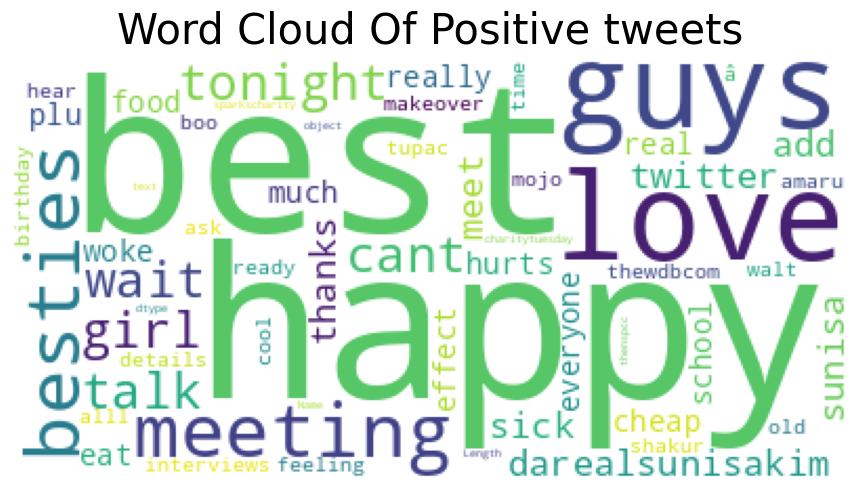

In [46]:
plot_wordcloud(positive_sent.text,title="Word Cloud Of Positive tweets",title_size=30)

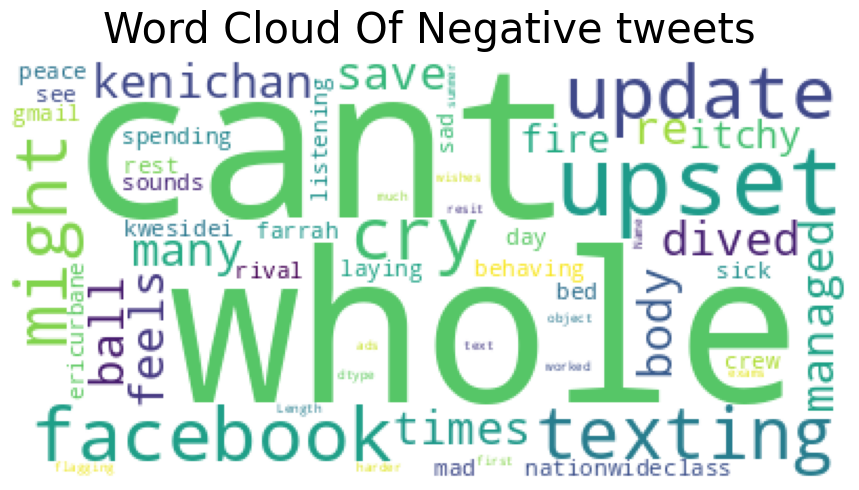

In [47]:
plot_wordcloud(negative_sent.text,title="Word Cloud Of Negative tweets",title_size=30)